In [1]:
import os
import numpy  as np 
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

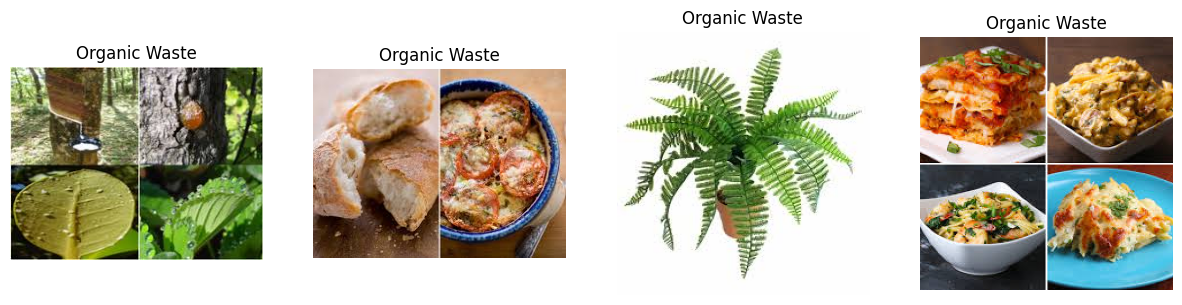

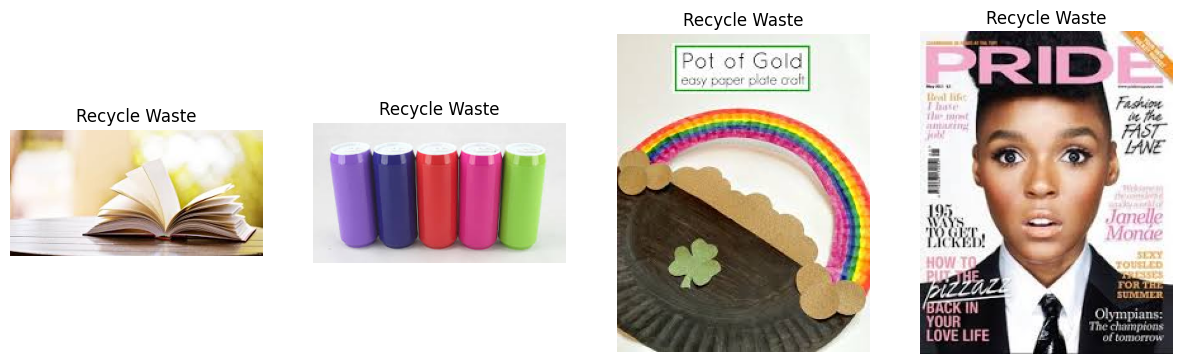

In [2]:
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    
    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)
    
    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)
    
    # Plot the random images
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        
        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')
    
    plt.show()

# Example usage: plot 4 random images from 'O' (Organic) and 'R' (Recyclable) categories
dataset_dir = 'DATASET\DATASET'
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)


In [3]:
train_directory = 'DATASET\DATASET\TRAIN'
test_directory = 'DATASET\DATASET\TEST'

In [4]:
train_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(
    #rescale = 1./255,
    preprocessing_function=preprocess_input
)

In [5]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="training",
    seed = 43
)

Found 18052 images belonging to 2 classes.


In [6]:
validation_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="validation",
    seed = 43
)

Found 4512 images belonging to 2 classes.


In [7]:
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True
)

Found 2513 images belonging to 2 classes.


In [8]:
# Define the core VGG16 model with pre-trained weights
core = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
core.trainable = False

# Define the sequential model
model = Sequential([
    core,
    Flatten(),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(50, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Define early stopping callback
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

# Define model checkpoint callback based on validation accuracy
checkpoint_path = "model_checkpoint.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[earlystopping, checkpoint])

Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8192 - loss: 1.0019  
Epoch 1: val_accuracy improved from -inf to 0.91733, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.8194 - loss: 0.9988 - val_accuracy: 0.9173 - val_loss: 0.2286
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8889 - loss: 0.3036  
Epoch 2: val_accuracy improved from 0.91733 to 0.92309, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 487s 3s/step - accuracy: 0.8889 - loss: 0.3035 - val_accuracy: 0.9231 - val_loss: 0.2215
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9055 - loss: 0.2617  
Epoch 3: val_accuracy improved from 0.92309 to 0.92398, saving model to model_checkpoint.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 506s 4s/step - accuracy: 0.9055 - loss: 0.2616 - val_accuracy: 0.9240 - val_loss: 0.2154
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9181 - loss: 0.2183  
Epoch 4: val_acc

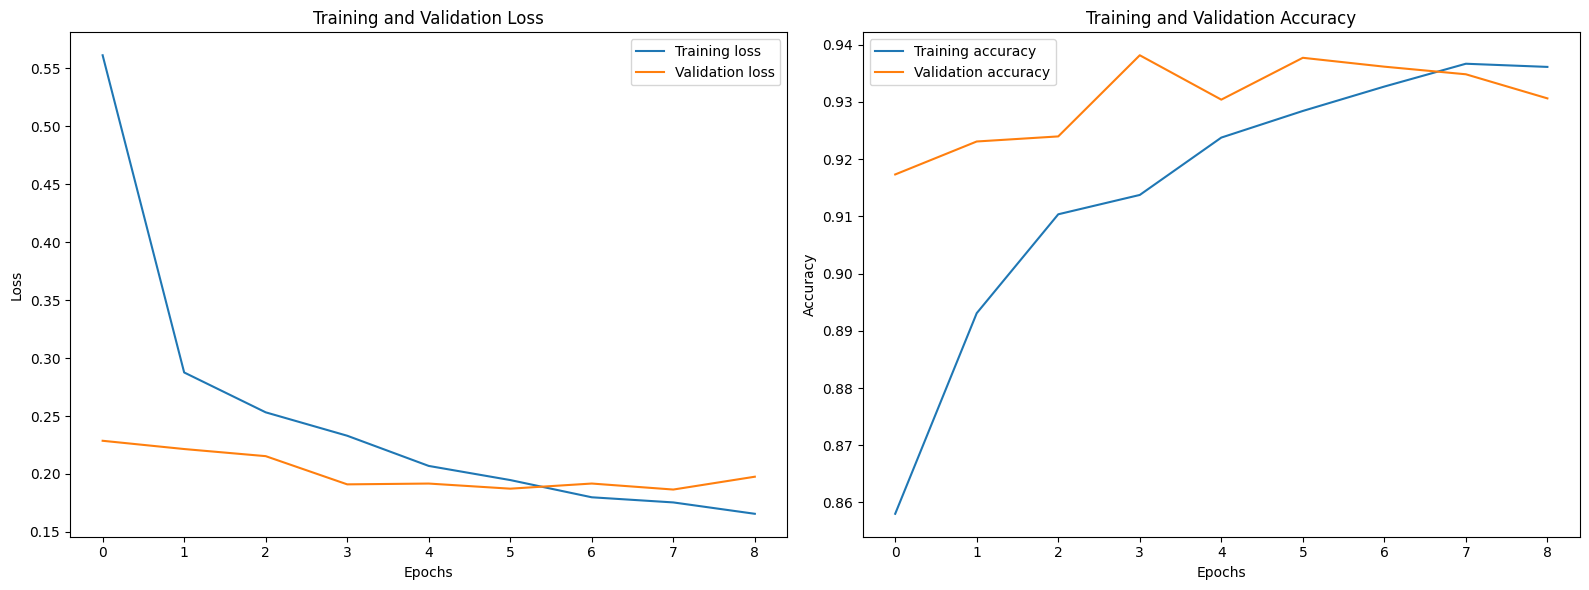

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    """
    Plot training and validation metrics over epochs.

    Parameters:
        history (History): History object returned by model.fit().
        metrics (list): List of metrics to plot (e.g., ['loss', 'accuracy']).
        figsize (tuple): Figure size (width, height) in inches.

    Returns:
        None
    """
    # Create subplots based on the number of metrics
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i)
        plt.plot(history.epoch, history.history[metric], label='Training ' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' contains the training history object
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))


In [10]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9050 - loss: 0.2962
test Loss: 0.3029
test Accuracy: 90.45%
